In [1]:
import numpy as np
import pandas as pd
import yfinance
import pandas_ta as ta

# Data
- Open
- High
- Low
- Close
- Volume
- PE
- PS
- EV_EBITDA
- Put Call Ratio

In [25]:
ticker = 'MSFT'
start = '2004-01-02'
end = {
    'AAPL': '2021-09-21',
    'MSFT': '2020-09-29',
    'AMZN': '2020-09-29',
    'SPY': "2023-02-20"
}
def get_yfdata(yf_ticker, cols):
    yf_data = yfinance.download(yf_ticker, start = start, end=end[ticker])
    yf_data = yf_data.rename(columns={'Open':'open', 'High': 'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})
    yf_data.drop(columns=['Adj Close'])
    print(yf_ticker, yf_data.shape)
    return yf_data[cols]

In [26]:
df = get_yfdata(ticker, ['open', 'high', 'low', 'close','volume'])
df.head()

[*********************100%***********************]  1 of 1 completed
MSFT (4214, 6)


,open,high,low,close,volume
Date,,,,,
2004-01-02,27.580000,27.770000,27.330000,27.450001,44487700
2004-01-05,27.730000,28.180000,27.719999,28.139999,67333700
2004-01-06,28.190001,28.280001,28.070000,28.240000,46950800
2004-01-07,28.170000,28.309999,28.010000,28.209999,54298200
2004-01-08,28.389999,28.480000,28.000000,28.160000,58810800


In [27]:
ratios = [('EV EBITDA Ratio','EV_EBITDA'),('PE Ratio', 'PE'),('PS Ratio', 'PS'),('Put Call Ratio', 'PutCall')]
for ratio in ratios:
    x = pd.read_csv(f'data/raw/{ticker} {ratio[0]}.csv', index_col=0)
    x = x.rename(columns={x.columns[0]: ratio[1]})
    x.index = pd.to_datetime(x.index)
    df = df.join(x, how='outer')
df.head()

,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall
2002-01-02,NaN,NaN,NaN,NaN,NaN,23.8147,42.1635,13.4297,1.9567
2002-01-03,NaN,NaN,NaN,NaN,NaN,24.6848,43.5409,13.8684,0.2157
2002-01-04,NaN,NaN,NaN,NaN,NaN,24.5537,43.3333,13.8023,1.5566
2002-01-07,NaN,NaN,NaN,NaN,NaN,24.4186,43.1195,13.7341,1.4556
2002-01-08,NaN,NaN,NaN,NaN,NaN,24.7444,43.6352,13.8984,1.2844


In [28]:
df.isna().sum()

open         1123
high         1123
low          1123
close        1123
volume       1123
EV_EBITDA       0
PE              1
PS              1
PutCall         1
dtype: int64

In [29]:
# preprocessing
df['!close_pct'] = df['close'].pct_change()
df['!open'] = df['open']
df['!close'] = df['close']
df['!high'] = df['high']
df['!low'] = df['low']
from scipy.stats.mstats import gmean
for col in df.columns:
    if '!' not in col:
        df[col] = df[col].pct_change()
        df[col] = df[col].apply(lambda x: x+1).rolling(window=5, min_periods=1).apply(gmean).apply(lambda x: x-1)
df = df.dropna()
print(df.shape)
df.head()

(4209, 14)


,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall,!close_pct,!open,!close,!high,!low
2004-01-09,0.003242,0.002080,0.001895,0.001525,0.085602,0.001854,0.001526,0.001525,-0.169797,-0.017756,28.030001,27.660000,28.059999,27.590000
2004-01-12,-0.000433,-0.003214,-0.002684,-0.004084,-0.036724,-0.004950,-0.004084,-0.004085,0.146343,-0.003254,27.670000,27.570000,27.730000,27.350000
2004-01-13,-0.004582,-0.004568,-0.005839,-0.005804,0.018889,-0.007034,-0.005803,-0.005802,0.016211,-0.005078,27.549999,27.430000,27.639999,27.260000
2004-01-14,-0.004658,-0.004131,-0.003886,-0.003642,-0.041594,-0.004411,-0.003643,-0.003640,0.017599,0.009843,27.520000,27.700001,27.730000,27.469999
2004-01-15,-0.005989,-0.005395,-0.004178,-0.004443,-0.001045,-0.005385,-0.004443,-0.004444,-0.137667,-0.005776,27.549999,27.540001,27.719999,27.420000


In [30]:
df.tail()

,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall,!close_pct,!open,!close,!high,!low
2020-09-22,-0.003245,-0.001607,-0.004732,-0.001306,0.089599,-0.001353,-0.001306,-0.001307,-0.004550,0.024094,205.059998,207.419998,208.100006,202.080002
2020-09-23,-0.002596,-0.002433,-0.004547,-0.004389,0.031898,-0.004550,-0.004389,-0.004389,-0.069127,-0.032928,207.899994,200.589996,208.100006,200.029999
2020-09-24,-0.000200,0.001211,-0.000761,0.000276,-0.017091,0.000286,0.000275,0.000276,-0.052226,0.012962,199.850006,203.190002,205.570007,199.199997
2020-09-25,0.000739,0.005238,0.006330,0.007308,-0.118237,0.007576,0.007308,0.007308,-0.020229,0.022787,203.550003,207.820007,209.039993,202.539993
2020-09-28,0.013515,0.009544,0.011622,0.006722,-0.042850,0.006967,0.006722,0.006723,-0.050277,0.007795,210.880005,209.440002,212.570007,208.059998


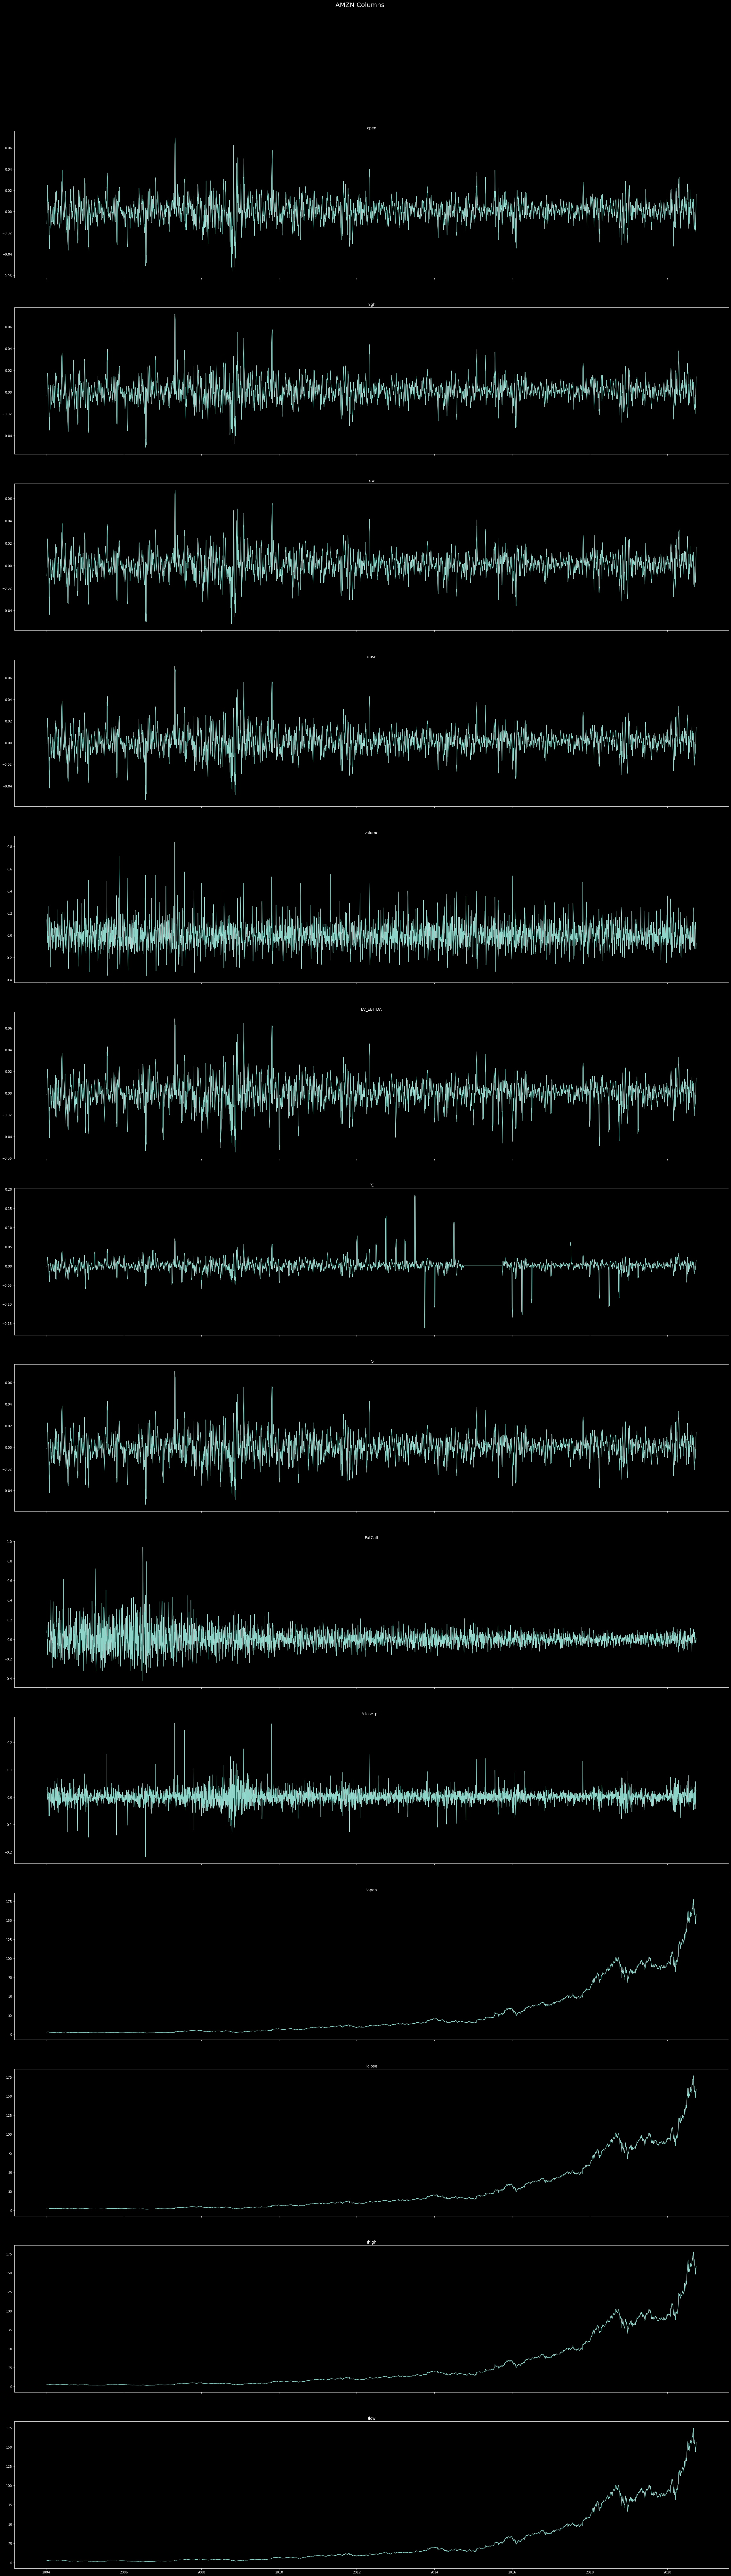

In [26]:
from utils.plot_utils import *
plot_cols(df, ticker)

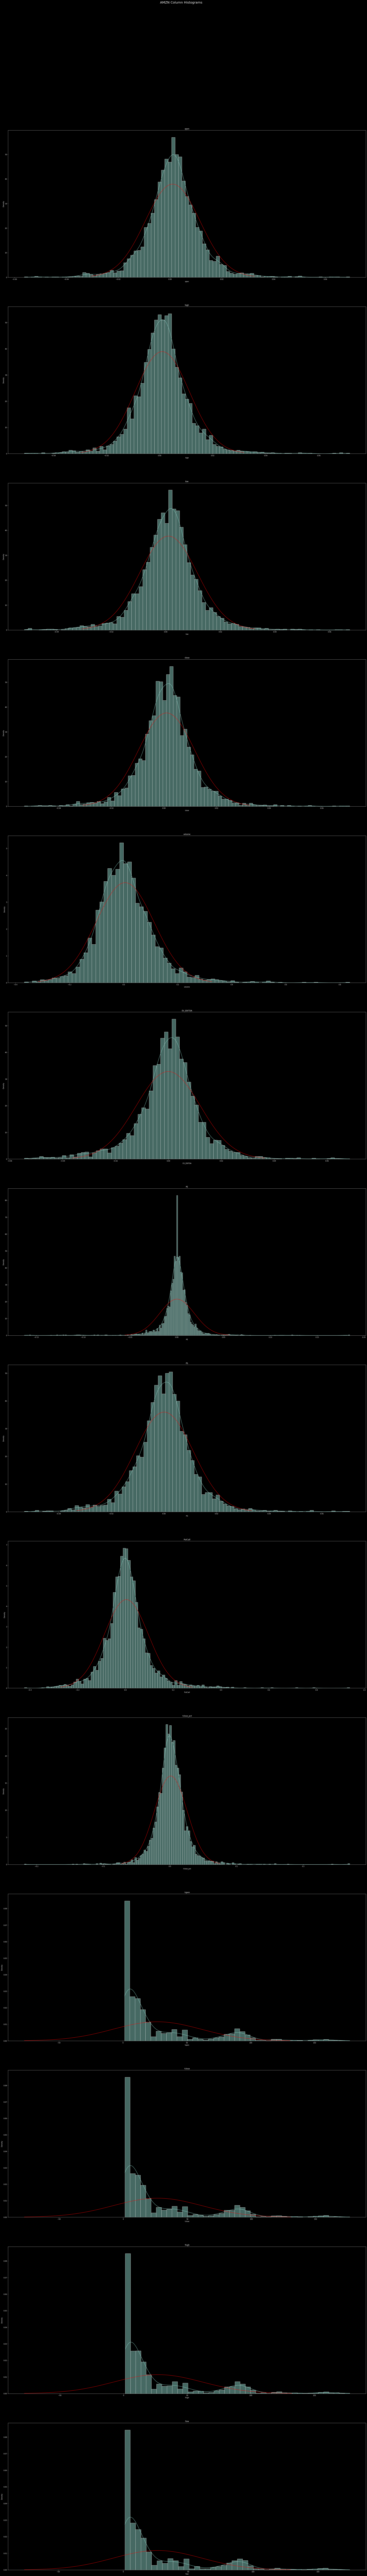

In [27]:
plot_col_histogram(df, ticker)

In [31]:
df_train = df.iloc[:int(0.8*df.shape[0]),:]
df_val = df.iloc[int(0.8*df.shape[0]):int(0.9*df.shape[0]),:]
df_test = df.iloc[int(0.9*df.shape[0]):,:]
df_train.shape

(3367, 14)

In [1]:
from utils.preprocessing_utils import *

In [33]:
X_cols = [col for col in df.columns if '!' not in col and col!='^IRX']
df_train_fixed, outliers = get_outliers(df_train, X_cols, iqr_mult=1.5, replace=True)

(3367, 14)
open: (-0.013678497733602357, 0.014405946799086744) High Outliers = 65, Low Outliers = 97, Total Outliers = 162
high: (-0.013408857917974082, 0.013964178231442581) High Outliers = 61, Low Outliers = 98, Total Outliers = 159
low: (-0.013303821815073946, 0.014193847235515533) High Outliers = 60, Low Outliers = 118, Total Outliers = 178
close: (-0.0139396994789322, 0.014631090012634795) High Outliers = 60, Low Outliers = 99, Total Outliers = 159
volume: (-0.20800017511034505, 0.20926752142385022) High Outliers = 83, Low Outliers = 37, Total Outliers = 120
EV_EBITDA: (-0.0178190901901491, 0.018042704499259543) High Outliers = 73, Low Outliers = 130, Total Outliers = 203
PE: (-0.01488682737912811, 0.015294206680034728) High Outliers = 68, Low Outliers = 114, Total Outliers = 182
PS: (-0.014883450167644197, 0.01491816954982289) High Outliers = 56, Low Outliers = 100, Total Outliers = 156
PutCall: (-0.3327985404736678, 0.33430079152628334) High Outliers = 80, Low Outliers = 23, Tot

In [ ]:
plot_col_histogram(df_train[~outliers][X_cols], ticker)

In [ ]:
plot_col_histogram(df_train_fixed, ticker)

In [35]:
df_train_norm, df_val_norm, df_test_norm, scalers = standardize_and_scale(df_train, df_val, df_test, outliers=outliers)
df_train_norm.head()

{'open': RobustScaler(), 'high': RobustScaler(), 'low': RobustScaler(), 'close': RobustScaler(), 'volume': RobustScaler(), 'EV_EBITDA': RobustScaler(), 'PE': RobustScaler(), 'PS': RobustScaler(), 'PutCall': RobustScaler()}


,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall,!close_pct,!open,!close,!high,!low
2004-01-09,0.406483,0.248967,0.212038,0.154224,0.833195,0.166238,0.154645,0.177824,-1.024223,-0.017756,28.030001,27.660000,28.059999,27.590000
2004-01-12,-0.116976,-0.524680,-0.454111,-0.631164,-0.339441,-0.592606,-0.588871,-0.575171,0.871383,-0.003254,27.670000,27.570000,27.730000,27.350000
2004-01-13,-0.707953,-0.722444,-0.913083,-0.871845,0.193681,-0.825080,-0.816712,-0.805618,0.091103,-0.005078,27.549999,27.430000,27.639999,27.260000
2004-01-14,-0.718720,-0.658699,-0.628954,-0.569249,-0.386121,-0.532474,-0.530352,-0.515505,0.099422,0.009843,27.520000,27.700001,27.730000,27.469999
2004-01-15,-0.908270,-0.843332,-0.671396,-0.681328,0.002584,-0.641153,-0.636406,-0.623367,-0.831571,-0.005776,27.549999,27.540001,27.719999,27.420000


In [36]:
val_features = [r[1] for r in ratios]

(3367, 14)
(3367, 4) Index(['EV_EBITDA', 'PE', 'PS', 'PutCall'], dtype='object')
(3367, 4)
[0.72587161 0.20850775 0.05290078 0.01271986]


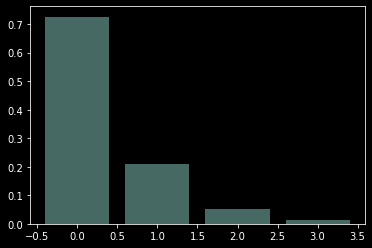

,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall,!close_pct,!open,!close,!high,!low,val_pca*_0,val_pca*_1,val_pca*_2,val_pca*_3
2004-01-09,0.406483,0.248967,0.212038,0.154224,0.833195,0.166238,0.154645,0.177824,-1.024223,-0.017756,28.030001,27.660000,28.059999,27.590000,-0.445876,-1.051857,0.002352,0.021609
2004-01-12,-0.116976,-0.524680,-0.454111,-0.631164,-0.339441,-0.592606,-0.588871,-0.575171,0.871383,-0.003254,27.670000,27.570000,27.730000,27.350000,0.993538,0.741275,0.034465,-0.005215
2004-01-13,-0.707953,-0.722444,-0.913083,-0.871845,0.193681,-0.825080,-0.816712,-0.805618,0.091103,-0.005078,27.549999,27.430000,27.639999,27.260000,1.332668,-0.066578,0.048005,-0.014123
2004-01-14,-0.718720,-0.658699,-0.628954,-0.569249,-0.386121,-0.532474,-0.530352,-0.515505,0.099422,0.009843,27.520000,27.700001,27.730000,27.469999,0.833225,-0.020841,0.033835,-0.003246
2004-01-15,-0.908270,-0.843332,-0.671396,-0.681328,0.002584,-0.641153,-0.636406,-0.623367,-0.831571,-0.005776,27.549999,27.540001,27.719999,27.420000,0.949246,-0.963123,0.041545,-0.008187


In [38]:
df_train_norm, df_val_norm, df_test_norm = add_PCA(val_features, df_train_norm, df_val_norm, df_test_norm, n_components=None, prefix='val_', append=True)
df_train_norm.head()

(3367, 18)
(3367, 5) Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')
(3367, 5)
[0.77926737 0.17771754 0.029474   0.00897991 0.00456118]


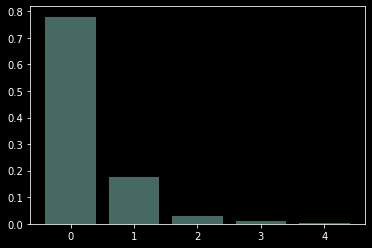

,open,high,low,close,volume,EV_EBITDA,PE,PS,PutCall,!close_pct,...,!low,val_pca*_0,val_pca*_1,val_pca*_2,val_pca*_3,tech_pca*_0,tech_pca*_1,tech_pca*_2,tech_pca_3,tech_pca_4
2004-01-09,0.406483,0.248967,0.212038,0.154224,0.833195,0.166238,0.154645,0.177824,-1.024223,-0.017756,...,27.590000,-0.445876,-1.051857,0.002352,0.021609,-0.525641,0.789482,0.189795,-0.083641,-0.057817
2004-01-12,-0.116976,-0.524680,-0.454111,-0.631164,-0.339441,-0.592606,-0.588871,-0.575171,0.871383,-0.003254,...,27.350000,0.993538,0.741275,0.034465,-0.005215,0.822941,-0.414876,0.354594,0.019448,-0.093414
2004-01-13,-0.707953,-0.722444,-0.913083,-0.871845,0.193681,-0.825080,-0.816712,-0.805618,0.091103,-0.005078,...,27.260000,1.332668,-0.066578,0.048005,-0.014123,1.578394,0.124163,0.100949,0.094357,0.006323
2004-01-14,-0.718720,-0.658699,-0.628954,-0.569249,-0.386121,-0.532474,-0.530352,-0.515505,0.099422,0.009843,...,27.469999,0.833225,-0.020841,0.033835,-0.003246,1.242113,-0.463200,-0.120067,0.020380,0.021892
2004-01-15,-0.908270,-0.843332,-0.671396,-0.681328,0.002584,-0.641153,-0.636406,-0.623367,-0.831571,-0.005776,...,27.420000,0.949246,-0.963123,0.041545,-0.008187,1.512633,-0.100797,-0.164841,-0.145899,0.057994


In [39]:
PCA_col = [col for col in df.columns if '!' not in col and 'Y_' not in col and col not in val_features]
df_train_norm, df_val_norm, df_test_norm = add_PCA(PCA_col, df_train_norm, df_val_norm, df_test_norm, prefix='tech_', append=True)
# add_PCA(PCA_col, df_train_pca, df_val_pca, df_test_pca, append=False)
df_train_norm.head()

In [40]:
df_train_norm['Y_reg'] = df_train_norm['close'].shift(-1)
df_train_norm.loc[df_train_norm.index[-1], 'Y_reg'] = df_val_norm.loc[df_val_norm.index[0], 'close']

df_val_norm['Y_reg'] = df_val_norm['close'].shift(-1)
df_val_norm.loc[df_val_norm.index[-1], 'Y_reg'] = df_test_norm.loc[df_test_norm.index[0], 'close']

df_test_norm['Y_reg'] = df_test_norm['close'].shift(-1)
df_test_norm.dropna(inplace=True)

In [41]:
df_test_norm.isna().sum()

open           0
high           0
low            0
close          0
volume         0
EV_EBITDA      0
PE             0
PS             0
PutCall        0
!close_pct     0
!open          0
!close         0
!high          0
!low           0
val_pca*_0     0
val_pca*_1     0
val_pca*_2     0
val_pca*_3     0
tech_pca*_0    0
tech_pca*_1    0
tech_pca*_2    0
tech_pca_3     0
tech_pca_4     0
Y_reg          0
dtype: int64

In [42]:
import pickle

df_train_norm.to_csv(f'data/processed/value/{ticker}_value_train.csv')
df_val_norm.to_csv(f'data/processed/value/{ticker}_value_val.csv')
df_test_norm.to_csv(f'data/processed/value/{ticker}_value_test.csv')
with open(f'data/processed/value/{ticker}_scalers.pickle', mode='wb',) as f: pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)